# Analyzing Erlangen Restaurants with German Cuisine using Yelp Data
## Introduction
**Goal:** The primary objective of this project is to gain insights into the German cuisine restaurant landscape in Erlangen using data extracted from Yelp, find the top-10 restaurants using the weighted rating formula and visualize their location on the map.

**Data Source:** The data will be scraped from Yelp's webpage dedicated to German cuisine restaurants in Erlangen. The link to the data source is [here](https://www.yelp.com/search?find_desc=Restaurants&find_loc=Erlangen%2C+BY&attrs=german).

## Step 1: Data Collection
### 1.1. Web Scraping Tool Setup
Before diving into scraping the website, it's imperative to set up the necessary tools and libraries. Web scraping often requires a combination of fetching web content and parsing the HTML to extract required information.

**Python Libraries:**
- `requests`: To fetch the webpage content.
- `BeautifulSoup`: From the bs4 library, used to parse the HTML content and extract data.

In [1]:
import requests
import re
from bs4 import BeautifulSoup
import json
import pandas as pd
import html
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from geopy.geocoders import ArcGIS

### 1.2. Fetching and Parsing the Webpage
In this step, our main objective is to fetch the content of the Yelp website, particularly the German cuisine restaurants in Erlangen. We are not just limiting our scraping to the first page; instead, we aim to fetch all 8 pages, as each page contains details of 10 restaurants. By collecting data from all the pages, we will have comprehensive information about 80 restaurants.

To achieve this, we'll:
- Use the `requests` library to fetch the webpage content.
- Employ `BeautifulSoup` to parse and navigate through the HTML structure of the fetched content.
- Loop through each page and store the parsed data accordingly.

In [2]:
base_url = "https://www.yelp.com/search?find_desc=Restaurants&find_loc=Erlangen%2C+BY&attrs=german&start={}"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

all_soups = []

for i in range(0, 80, 10):
    response = requests.get(base_url.format(i), headers=headers, timeout=100)
    if response.status_code != 200:
        raise Exception(f"Webpage fetch failed for page starting at {i}! Status code: {response.status_code}")
    soup = BeautifulSoup(response.content, 'html.parser')
    all_soups.append(soup)

## Step 2: Extracting Restaurant Details
Now that we have fetched and parsed the webpage content, the next logical step is to extract detailed information about each restaurant. Upon inspecting the HTML content of the Yelp page, we can see that restaurant details are embedded within the webpage as structured JSON data, which follows the `schema.org` format. This makes our task a bit easier, as this format provides a standardized way of representing data.

Let's use this to extract the details :

- Identifying the Right Script Tag: Navigate through the parsed content to find the `<script>` tag that contains our required JSON data. The presence of keywords like `@context`, `@type`, and `ImageObject` helps in identifying the correct script.

- Parsing JSON Content: Once the right script content is identified, attempt to parse it using the `json` module. Sometimes, however, the content might have additional JavaScript code, so a secondary approach is added using `regex` to capture only the required JSON data.

- Extracting Relevant Fields: With the parsed JSON data in hand, we loop through each entry and extract relevant details like restaurant name, address, review count, and rating.

- Storing the Information: We store the extracted information in a structured manner for further analysis.

In [3]:
restaurants = []

def extract_details(soup):
    script_content = None
    for script in soup.find_all("script"):
        if "@context" in script.text and "@type" in script.text and "ImageObject" in script.text:
            script_content = script.text
            break

    if not script_content:
        print("Script containing restaurant data not found!")
        return

    try:
        data = json.loads(script_content)
    except json.JSONDecodeError:
        match = re.search(r'\[.*\]', script_content)
        if match:
            data_str = match.group(0)
            data = json.loads(data_str)
        else:
            print("Failed to parse JSON.")
            return

    for entry in data:
        if (
            entry.get("@type") == "ImageObject" and 
            entry.get("contentLocation") and 
            entry.get("contentLocation").get("address") and 
            entry.get("aggregateRating")
        ):
            address_info = entry["contentLocation"]["address"]
            restaurant_name = entry["aggregateRating"]["itemReviewed"]["name"]
            street_address = address_info["streetAddress"]
            review_count = entry["aggregateRating"]["reviewCount"]
            rating = entry["aggregateRating"]["ratingValue"]

            restaurants.append({
                'Name': restaurant_name,
                'Address': street_address,
                'Review Count': review_count,
                'Rating': rating
            })

for soup in all_soups:
    extract_details(soup)

for restaurant in restaurants[:3]:  
    print(f"Name: {restaurant['Name']}")
    print(f"Address: {restaurant['Address']}")
    print(f"Review Count: {restaurant['Review Count']}")
    print(f"Rating: {restaurant['Rating']}")
    print('-' * 50)

print(f"We have details on {len(restaurants)} German cuisine restaurants in Erlangen.")

Name: Kitzmann BräuSchänke
Address: Südliche Stadtmauerstr. 25
Review Count: 30
Rating: 3.9
--------------------------------------------------
Name: Steinbach Bräu
Address: Vierzigmannstr. 4
Review Count: 35
Rating: 4.4
--------------------------------------------------
Name: Blaue Traube
Address: Luitpoldstr. 24
Review Count: 20
Rating: 4.9
--------------------------------------------------
We have details on 41 German cuisine restaurants in Erlangen.


## Step 3: Analyzing and Visualizing the Restaurant Data

- **Data Structuring:** We'll start by transferring our scraped data into a Pandas DataFrame. DataFrames offer a plethora of functionalities to handle, analyze, and visualize structured data.

- **Feature Engineering:** We'll compute a weighted rating for each restaurant. The rationale is that a restaurant with a high rating but only a few reviews should not necessarily rank higher than a restaurant with a slightly lower rating but hundreds of reviews. Although Yelps's ratings are probably considering the count factor, we want to introduce the weighted rating to balance the influence of the average rating with the number of reviews. 

- **Ranking Restaurants:** Based on the weighted rating, we'll rank the restaurants and display the top 10.

- **Visualizations:** We'll create some visual plots to better understand the distribution of ratings, the number of reviews, and any other interesting trends.

### 3.1. Data Structuring
First, we need to convert our restaurants list into a DataFrame.

In [4]:
for restaurant in restaurants:
    restaurant['Name'] = html.unescape(restaurant['Name'])

df_restaurants = pd.DataFrame(restaurants)
df_restaurants['Rating'] = df_restaurants['Rating'].round(2)
df_restaurants.head()

,Name,Address,Review Count,Rating
0,Kitzmann BräuSchänke,Südliche Stadtmauerstr. 25,30,3.9
1,Steinbach Bräu,Vierzigmannstr. 4,35,4.4
2,Blaue Traube,Luitpoldstr. 24,20,4.9
3,Mein lieber Schwan,Hauptstr. 110,16,4.5
4,Salz und Pfeffer,Hartmannstr. 19,30,4.2


### 3.2. Feature Engineering: Weighted Rating
We can get weighted ratings using the IMDB's weighted rating formula:

$\text{Weighted Rating (WR)} = \left( \frac{v}{v+m} \times R \right) + \left( \frac{m}{v+m} \times C \right)$

Where:
- $ v $ is the number of reviews for the restaurant (Review Count).
- $ m $ is the minimum number of reviews required for the restaurant to be listed (we will use the 25th percentile of the review counts, so that new/less popular restaurants are not ignored).
- $R $ is the average rating of the restaurant.
- $ C $ is the mean rating across the entire dataset.


In [5]:
C = df_restaurants['Rating'].mean()
m = df_restaurants['Review Count'].quantile(0.25)

qualified = df_restaurants.copy().loc[df_restaurants['Review Count'] >= m]
qualified['Weighted Rating'] = round((qualified['Review Count'] / (qualified['Review Count'] + m) * qualified['Rating']) + (m / (qualified['Review Count'] + m) * C),2)



### 3.3. Ranking Restaurants

Now let's get the top 10 German cuisine restaurants in Erlangen based on the weighted rating:

In [6]:
qualified = qualified.sort_values('Weighted Rating', ascending=False)
qualified.head(10)

,Name,Address,Review Count,Rating,Weighted Rating
2,Blaue Traube,Luitpoldstr. 24,20,4.90,4.75
5,Altmann's Stube,Theaterplatz 9,4,5.00,4.50
21,Goldner Schaumlöfel,Wallenrodstr. 5,4,5.00,4.50
3,Mein lieber Schwan,Hauptstr. 110,16,4.50,4.40
1,Steinbach Bräu,Vierzigmannstr. 4,35,4.40,4.36
6,Pizza-Bar Luigino Cescutti,Hartmannstr. 7,10,4.40,4.29
7,Gasthaus Spezerei,Wöhrstr. 1,10,4.40,4.29
17,Schwarzstark,Henkestr. 91,4,4.50,4.25
28,Restaurant Höfler,Reutleser Str. 59 - 61,5,4.40,4.23
12,Muskat,Hauptstr. 60,9,4.33,4.23


According to the weighted rating, the top-rated restaurant is the Blaue Traube.

### 3.4 Visualizations

Let's get more insights into the german cuisine restaurants ratings in Erlangen. We can start by visualizing the distribution of restaurant ratings.

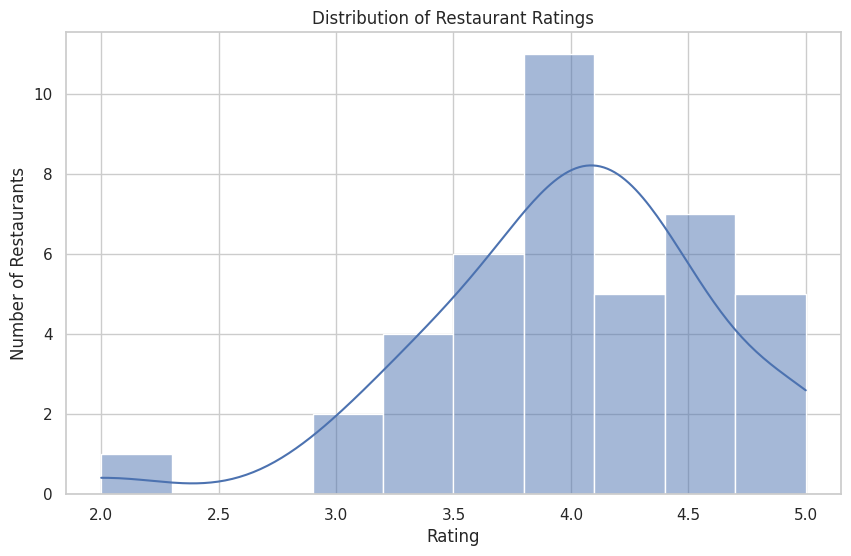

In [7]:

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(df_restaurants['Rating'], bins=10, kde=True)
plt.title('Distribution of Restaurant Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Restaurants')
plt.show()


Seems that most German cuisine restaurants are rated 4.0 and above, though there are a couple with a score under 3.5.

Let's investigate weighted ratings as well:

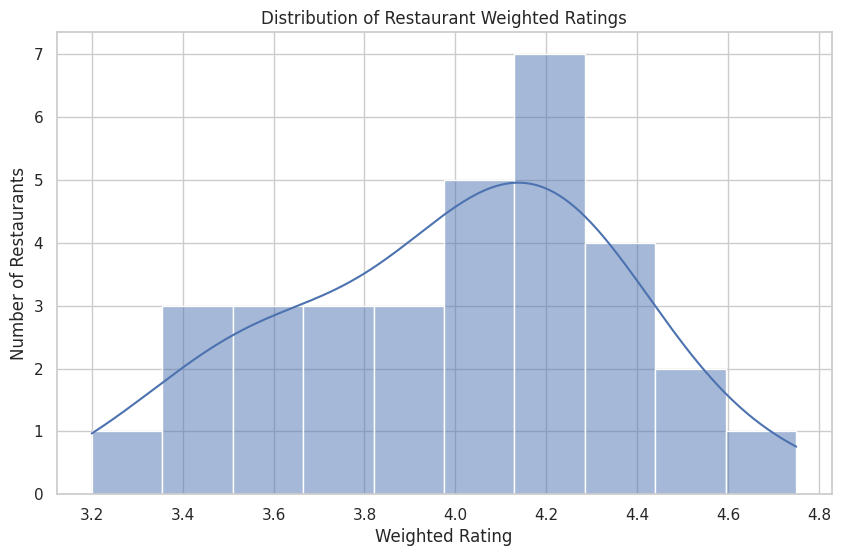

In [8]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(qualified['Weighted Rating'], bins=10, kde=True)
plt.title('Distribution of Restaurant Weighted Ratings')
plt.xlabel('Weighted Rating')
plt.ylabel('Number of Restaurants')
plt.show()

Weighted ratings are quite dense, and the most common score here is  4.2.

## Step 4. Top 10 German Cuisine Restaurants in Erlangen on the Map

Finally, let's show the location of the top 10 restaurants on the map of Erlangen.

First, we need to get longitude and latitude for each restaurant using the address:

In [9]:
top_10 = qualified[:10]

geolocator = ArcGIS(user_agent="geoapiExercises")

def get_lat_lon(address):
    location = geolocator.geocode(address + ", Erlangen, Germany")
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

top_10_copy = top_10.copy()
latitudes, longitudes = zip(*top_10_copy['Address'].apply(get_lat_lon))
top_10_copy['Latitude'] = latitudes
top_10_copy['Longitude'] = longitudes
top_10_copy

,Name,Address,Review Count,Rating,Weighted Rating,Latitude,Longitude
2,Blaue Traube,Luitpoldstr. 24,20,4.90,4.75,49.59706,11.01674
5,Altmann's Stube,Theaterplatz 9,4,5.00,4.50,49.60064,11.00648
21,Goldner Schaumlöfel,Wallenrodstr. 5,4,5.00,4.50,49.56771,10.96078
3,Mein lieber Schwan,Hauptstr. 110,16,4.50,4.40,49.60268,11.00400
1,Steinbach Bräu,Vierzigmannstr. 4,35,4.40,4.36,49.60289,11.00514
6,Pizza-Bar Luigino Cescutti,Hartmannstr. 7,10,4.40,4.29,49.59605,11.02242
7,Gasthaus Spezerei,Wöhrstr. 1,10,4.40,4.29,49.60347,11.00443
17,Schwarzstark,Henkestr. 91,4,4.50,4.25,49.59474,11.01817
28,Restaurant Höfler,Reutleser Str. 59 - 61,5,4.40,4.23,49.53365,11.02229
12,Muskat,Hauptstr. 60,9,4.33,4.23,49.59996,11.00317


And now we can display the location of the top-10 restaurants on the map:

In [10]:
m = folium.Map(location=[49.5971, 11.0063], zoom_start=13)

for index, row in top_10_copy.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['Name'],
        icon=folium.Icon(icon="cutlery", prefix='fa')
    ).add_to(m)

m

In [ ]:
m.save("erlangen_restaurants_map.html")